# 라이브러리

In [1]:
#lib
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image 
import cv2
import sys
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import layers as tfl, optimizers

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation

# 데이터 불러오기

In [2]:
# # 캐글연동
# !pip install kaggle
# from google.colab import files
# files.upload()

In [3]:
# ls -1ha kaggle.json

In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning이 발생하지 않도록 해줍니다.
# !chmod 600 ~/.kaggle/kaggle.json

In [5]:
# !kaggle datasets download -d divyansh22/dummy-astronomy-data

In [6]:
# !unzip dummy-astronomy-data.zip

In [7]:
#데이터 불러오기
data = []
labels =[]
import glob
galaxy_path = glob.glob('./Cutout Files/galaxy/*')
star_path = glob.glob('./Cutout Files/star/*')
for x in galaxy_path:
    image = cv2.imread(x,1)
    image= np.array(image)
    data.append(image)
    labels.append(0)
for x in star_path:
    image = cv2.imread(x,1)
    image= np.array(image)
    data.append(image)
    labels.append(1)   

In [8]:
data, labels= np.array(data), np.array(labels)

In [9]:
dataset= pd.DataFrame(list(zip(data, labels)), columns=['images','labels'])

In [10]:
dataset.head(5)

,images,labels
0,"[[[83, 83, 83], [115, 115, 115], [75, 75, 75],...",0
1,"[[[112, 112, 112], [61, 61, 61], [97, 97, 97],...",0
2,"[[[125, 125, 125], [74, 74, 74], [125, 125, 12...",0
3,"[[[23, 23, 23], [93, 93, 93], [77, 77, 77], [1...",0
4,"[[[86, 86, 86], [96, 96, 96], [50, 50, 50], [7...",0


# 데이터 분할

In [11]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42, shuffle=True,stratify=dataset['labels'].values)

x_test, x_valid, y_test, y_valid= train_test_split(x_test, y_test, test_size=0.2,
                                                random_state=42, shuffle=True)

In [12]:
y_train, y_valid= to_categorical(y_train),  to_categorical(y_valid)

In [13]:
x_train.shape,y_train.shape

((3188, 64, 64, 3), (3188, 2))

In [14]:
x_test.shape,y_test.shape

((638, 64, 64, 3), (638,))

# 데이터 확인

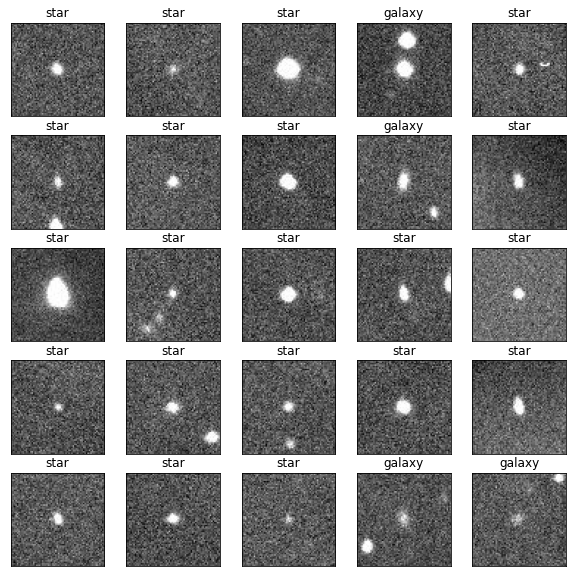

In [15]:
class_names=['star','galaxy']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    if y_test[i]==0:
    #if y_test[i][0]==0:
        plt.title('galaxy')
    else:
        plt.title('star')
    #plt.xlabel(class_names[y_train[i][0]])
plt.show()

# 모델링

## resnet50

In [16]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape = (64,64,3),classes=2)

for layer in resnet.layers:
    layer.trainable = False

In [17]:
from keras.layers import BatchNormalization,Dropout

x = resnet.output
x = Rescaling(scale=1./255)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x =  Dense(512, activation='relu', input_dim=(64,64,3))(x)
x = BatchNormalization()(x)
x =  Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=x)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [19]:
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [20]:
model.compile(
    optimizer= optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy', 
    metrics=METRICS
)

In [21]:
import os
paths = {'model_path' : os.path.join('models'), 
         'weights_path' : os.path.join('models','weights'),
         'saved_model_path' : os.path.join('models', 'saved_model'),
         'checkpoint_path' : os.path.join('models','checkpoints')
        }

## callback

In [22]:
# call back

# checkpoint - best model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_ckpt= ModelCheckpoint(
                        paths['checkpoint_path'], monitor='val_auc', verbose=1, save_best_only=True,
                         mode='max', save_freq='epoch')

# learning rate
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2,
                              patience=4, min_lr=0.001)

# es = EarlyStopping(monitor='val_prc', mode='auto', verbose=1,
#                   restore_best_weights=True,patience=10)

In [23]:
# x_train= tfl.Rescaling(scale=1./255)(x_train)
# x_valid=tfl.Rescaling(scale=1./255)(x_valid)

## fitting

In [24]:
epochs = 128
history = model.fit(x_train,y_train,validation_data=(x_valid,y_valid),
                    epochs=epochs,
                    verbose=1,
                    batch_size=32,
                    callbacks=[model_ckpt,reduce_lr]
                    #callbacks=[es]
                    )

Epoch 1/128
100/100 [==============================] - ETA: 0s - loss: 0.5059 - tp: 2468.0000 - fp: 720.0000 - tn: 2468.0000 - fn: 720.0000 - accuracy: 0.7742 - precision: 0.7742 - recall: 0.7742 - auc: 0.8534 - prc: 0.8441
Epoch 1: val_auc improved from -inf to 0.85176, saving model to models/checkpoints
INFO:tensorflow:Assets written to: models/checkpoints/assets
100/100 [==============================] - 35s 269ms/step - loss: 0.5059 - tp: 2468.0000 - fp: 720.0000 - tn: 2468.0000 - fn: 720.0000 - accuracy: 0.7742 - precision: 0.7742 - recall: 0.7742 - auc: 0.8534 - prc: 0.8441 - val_loss: 0.6267 - val_tp: 117.0000 - val_fp: 43.0000 - val_tn: 117.0000 - val_fn: 43.0000 - val_accuracy: 0.7312 - val_precision: 0.7312 - val_recall: 0.7312 - val_auc: 0.8518 - val_prc: 0.8602 - lr: 0.0100
Epoch 2/128
 98/100 [============================>.] - ETA: 0s - loss: 0.4283 - tp: 2513.0000 - fp: 623.0000 - tn: 2513.0000 - fn: 623.0000 - accuracy: 0.8013 - precision: 0.8013 - recall: 0.8013 - auc: 

In [25]:
# from tensorflow.keras.models import load_model
# loaded_model = load_model(paths['checkpoint_path'])
# loaded_model.summary()

# 시각화

## 훈련 과정 시각화

In [26]:
training_score= history.history

Text(0.5, 1.0, 'Loss Function')

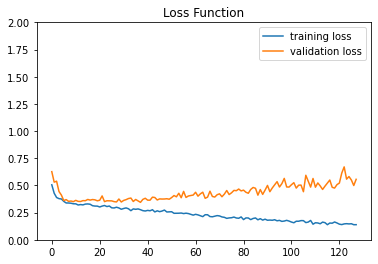

In [27]:
plt.plot(training_score['loss'], label='training loss')
plt.plot(training_score['val_loss'], label='validation loss')
plt.ylim(0,2)
plt.legend()
plt.title('Loss Function')

Text(0.5, 1.0, 'AUC Function')

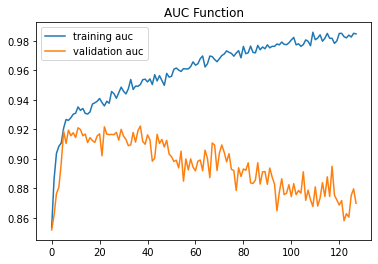

In [28]:
plt.plot(training_score['auc'], label='training auc')
plt.plot(training_score['val_auc'], label='validation auc')
plt.legend()
plt.title('AUC Function')

Text(0.5, 1.0, 'Precision Function')

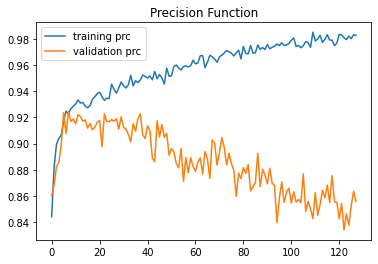

In [29]:
plt.plot(training_score['prc'], label='training prc')
plt.plot(training_score['val_prc'], label='validation prc')
plt.legend()
plt.title('Precision Function')

## 베스트 모델로 test 데이터의 ROC Curve 확인

In [30]:
model_name= 'resent_star_galaxy.h5'
model.save(paths['saved_model_path'] + model_name)

In [31]:
from sklearn.metrics import roc_curve, auc

In [32]:
loaded_saved_model= keras.models.load_model(paths['saved_model_path']+model_name)
loaded_saved_ckpt= keras.models.load_model(paths['checkpoint_path'])

In [33]:
def evaluate_results(x,y, classes):
    predicted_prob = loaded_saved_ckpt.predict(x)
    fpr= {}
    tpr ={}
    threshold_ ={}
    auc_ ={}
    for i in range(classes):
        fpr[i], tpr[i], threshold_[i]= roc_curve(y, predicted_prob[:,i], pos_label=i)
        auc_[i] = auc(fpr[i], tpr[i])      
    
    return fpr, tpr, threshold_, auc_    

In [34]:
num_classes= 2
fpr, tpr, threshold_, auc_score= evaluate_results(x_test,y_test, num_classes)

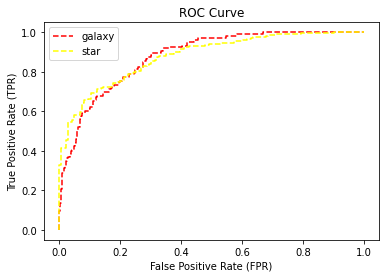

********** 
 AUC score for class GALAXY:  0.8782297583249806 
 ********** 
 AUC score for class STAR:  0.8782297583249806 
 **********


In [35]:
plt.plot(fpr[0],tpr[0], linestyle='--',color='red', label='galaxy')
plt.plot(fpr[1],tpr[1], linestyle='--',color='yellow', label='star')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()
print('*'*10,'\n','AUC score for class GALAXY: ', auc_score[0], '\n', '*'*10,'\n', 'AUC score for class STAR: ', auc_score[1], '\n', '*'*10)